In [23]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/disease_features.csv")
import ast

def parse_and_stringify(cell):
    if pd.isna(cell):
        return ""
    try:
        parsed = ast.literal_eval(cell)
        if isinstance(parsed, list):
            return " ".join([str(i).lower().strip() for i in parsed])
        else:
            return str(parsed).lower()
    except:
        return str(cell).lower()

df["Risk_Factors_Str"] = df["Risk Factors"].apply(parse_and_stringify)
df["Symptoms_Str"] = df["Symptoms"].apply(parse_and_stringify)
df["Signs_Str"] = df["Signs"].apply(parse_and_stringify)

vectorizer_risk = TfidfVectorizer()
vectorizer_symptoms = TfidfVectorizer()
vectorizer_signs = TfidfVectorizer()

tfidf_risk = vectorizer_risk.fit_transform(df["Risk_Factors_Str"])
tfidf_symptoms = vectorizer_symptoms.fit_transform(df["Symptoms_Str"])
tfidf_signs = vectorizer_signs.fit_transform(df["Signs_Str"])

tfidf_combined = hstack([tfidf_risk, tfidf_symptoms, tfidf_signs])

tfidf_df = pd.DataFrame(tfidf_combined.toarray())

one_hot_df = pd.read_csv("/content/drive/My Drive/encoded_output2.csv")
one_hot_matrix = one_hot_df.drop(columns=["Disease"]).to_numpy()


tfidf_total = tfidf_combined.shape[0] * tfidf_combined.shape[1]
tfidf_nonzero = tfidf_combined.count_nonzero()
tfidf_sparsity = 1 - (tfidf_nonzero / tfidf_total)

onehot_total = one_hot_matrix.shape[0] * one_hot_matrix.shape[1]
onehot_nonzero = (one_hot_matrix != 0).sum()
onehot_sparsity = 1 - (onehot_nonzero / onehot_total)

pd.DataFrame(tfidf_combined.toarray()).to_csv("/content/drive/My Drive/tfidf_matrix.csv", index=False)
pd.DataFrame(one_hot_matrix).to_csv("/content/drive/My Drive/onehot_matrix.csv", index=False)


print ("TF-IDF Analysis")
print("Matrix Shape:", tfidf_combined.shape)
print("Sparsity: {:.2f}%".format(tfidf_sparsity * 100))
print("Unique Features:", tfidf_combined.shape[1])


print("\nOne-Hot Analysis")
print("Matrix Shape:", one_hot_matrix.shape)
print("Sparsity: {:.2f}%".format(onehot_sparsity * 100))
print("Unique Features:", one_hot_matrix.shape[1])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TF-IDF Analysis
Matrix Shape: (25, 1020)
Sparsity: 92.96%
Unique Features: 1020

One-Hot Analysis
Matrix Shape: (25, 496)
Sparsity: 95.34%
Unique Features: 496



PCA TF-IDF Explained Variance Ratio: [0.06583265 0.05891733]
PCA One-Hot Explained Variance Ratio: [0.10538866 0.09170854]
SVD TF-IDF Explained Variance Ratio: [0.00884877 0.06543636]
SVD One-Hot Explained Variance Ratio: [0.02247785 0.09195055]


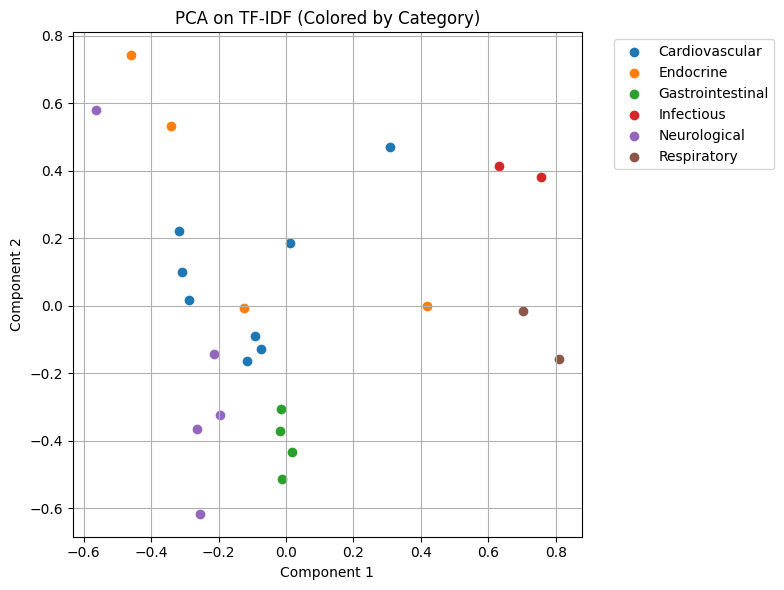

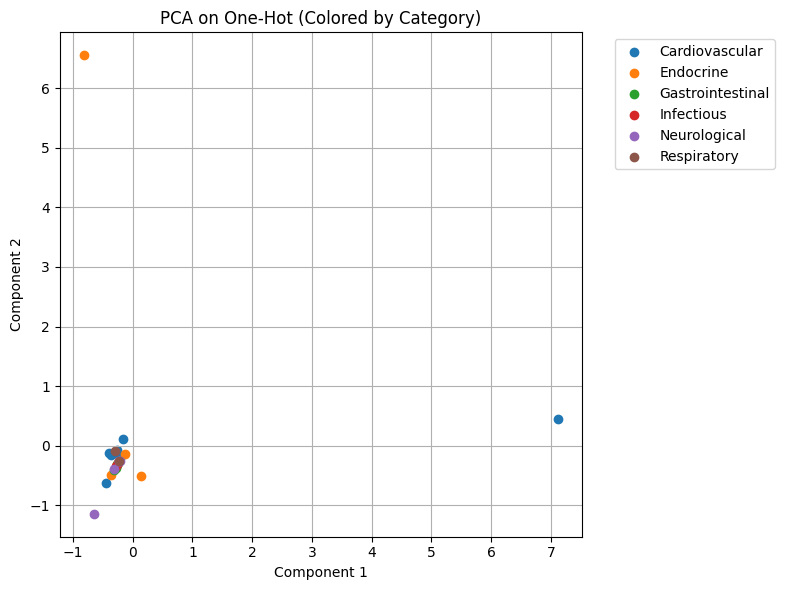

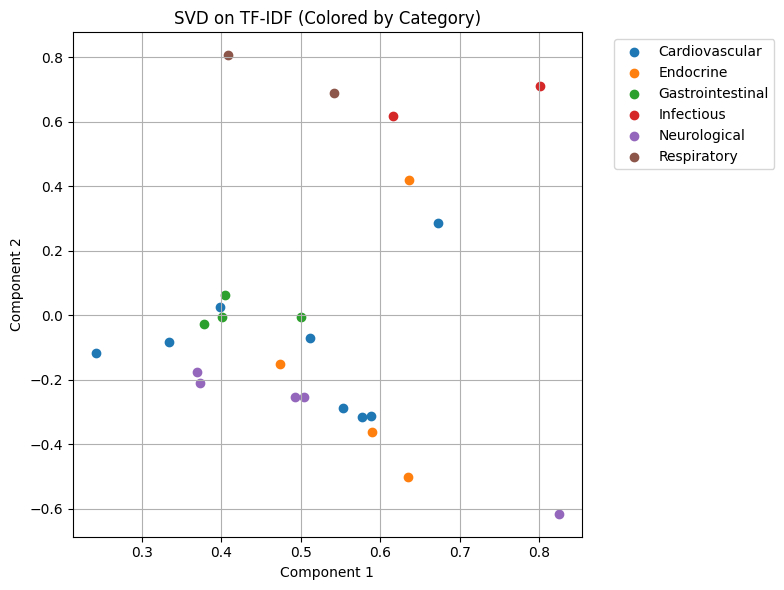

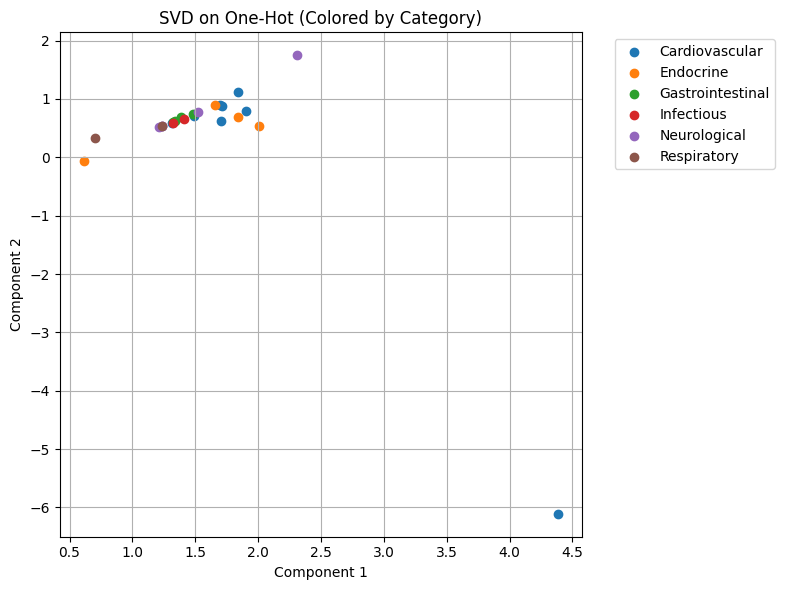

In [24]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np


pca_tfidf = PCA(n_components=2).fit_transform(tfidf_combined.toarray())
pca_onehot = PCA(n_components=2).fit_transform(one_hot_matrix)


svd_tfidf = TruncatedSVD(n_components=2).fit_transform(tfidf_combined)
svd_onehot = TruncatedSVD(n_components=2).fit_transform(one_hot_matrix)


print("\nPCA TF-IDF Explained Variance Ratio:", PCA(n_components=2).fit(tfidf_combined.toarray()).explained_variance_ratio_)
print("PCA One-Hot Explained Variance Ratio:", PCA(n_components=2).fit(one_hot_matrix).explained_variance_ratio_)
print("SVD TF-IDF Explained Variance Ratio:", TruncatedSVD(n_components=2).fit(tfidf_combined).explained_variance_ratio_)
print("SVD One-Hot Explained Variance Ratio:", TruncatedSVD(n_components=2).fit(one_hot_matrix).explained_variance_ratio_)


categories = np.array([
    "Cardiovascular", "Endocrine", "Neurological", "Cardiovascular", "Respiratory",
    "Cardiovascular", "Cardiovascular", "Respiratory", "Endocrine", "Neurological",
    "Gastrointestinal", "Gastrointestinal", "Cardiovascular", "Cardiovascular",
    "Cardiovascular", "Neurological", "Neurological", "Gastrointestinal", "Endocrine",
    "Infectious", "Cardiovascular", "Neurological", "Endocrine", "Infectious", "Gastrointestinal"
])

def plot_2d(data, labels, title):
    plt.figure(figsize=(8, 6))
    for cat in np.unique(labels):
        idx = labels == cat
        plt.scatter(data[idx, 0], data[idx, 1], label=cat)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_2d(pca_tfidf, categories, "PCA on TF-IDF (Colored by Category)")
plot_2d(pca_onehot, categories, "PCA on One-Hot (Colored by Category)")
plot_2d(svd_tfidf, categories, "SVD on TF-IDF (Colored by Category)")
plot_2d(svd_onehot, categories, "SVD on One-Hot (Colored by Category)")

In [25]:
!pip install imbalanced-learn

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score


le = LabelEncoder()
y_encoded = le.fit_transform(categories)

smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled_tfidf, y_resampled = smote.fit_resample(tfidf_combined, y_encoded)
X_resampled_onehot, _ = smote.fit_resample(one_hot_matrix, y_encoded)


scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0)
}

matrices_resampled = {
    'TF-IDF': X_resampled_tfidf,
    'One-Hot': X_resampled_onehot
}

ks = [3, 5, 7]
metrics = ['euclidean', 'manhattan', 'cosine']

results = []

for encoding, X in matrices_resampled.items():
    X = X if isinstance(X, np.ndarray) else X.toarray()

    for k in ks:
        for metric in metrics:
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            cv_results = cross_validate(knn, X, y_resampled, cv=5, scoring=scoring, error_score='raise')

            results.append({
                'Encoding': encoding,
                'k': k,
                'metric': metric,
                'accuracy': np.mean(cv_results['test_accuracy']),
                'precision': np.mean(cv_results['test_precision_weighted']),
                'recall': np.mean(cv_results['test_recall_weighted']),
                'f1': np.mean(cv_results['test_f1_weighted'])
            })

lr_results = []

for encoding, X in matrices_resampled.items():
    X = X if isinstance(X, np.ndarray) else X.toarray()

    lr = LogisticRegression(max_iter=1000)
    cv_results = cross_validate(lr, X, y_resampled, cv=5, scoring=scoring)

    lr_results.append({
        'Encoding': encoding,
        'Model': 'Logistic Regression',
        'accuracy': np.mean(cv_results['test_accuracy']),
        'precision': np.mean(cv_results['test_precision_weighted']),
        'recall': np.mean(cv_results['test_recall_weighted']),
        'f1': np.mean(cv_results['test_f1_weighted'])
    })

knn_df = pd.DataFrame(results)
lr_df = pd.DataFrame(lr_results)


best_knn_tfidf = knn_df.loc[knn_df[knn_df.Encoding == 'TF-IDF']['f1'].idxmax()]
best_knn_onehot = knn_df.loc[knn_df[knn_df.Encoding == 'One-Hot']['f1'].idxmax()]

print("\n🔸 KNN Results:")
print(knn_df)

print("\n🔸 Logistic Regression Results:")
print(lr_df)

print("\n🔸 Best KNN TF-IDF:")
print(best_knn_tfidf)

print("\n🔸 Best KNN One-Hot:")
print(best_knn_onehot)

print("\n🔸 Logistic Regression TF-IDF:")
print(lr_df[lr_df.Encoding == 'TF-IDF'].iloc[0])

print("\n🔸 Logistic Regression One-Hot:")
print(lr_df[lr_df.Encoding == 'One-Hot'].iloc[0])


🔸 KNN Results:
   Encoding  k     metric  accuracy  precision    recall        f1
0    TF-IDF  3  euclidean  0.837778   0.779630  0.837778  0.792222
1    TF-IDF  3  manhattan  0.877778   0.855556  0.877778  0.849778
2    TF-IDF  3     cosine  0.837778   0.823333  0.837778  0.815704
3    TF-IDF  5  euclidean  0.777778   0.728963  0.777778  0.737746
4    TF-IDF  5  manhattan  0.773333   0.756370  0.773333  0.731746
5    TF-IDF  5     cosine  0.795556   0.792963  0.795556  0.767926
6    TF-IDF  7  euclidean  0.735556   0.672481  0.735556  0.685376
7    TF-IDF  7  manhattan  0.666667   0.574889  0.666667  0.590265
8    TF-IDF  7     cosine  0.817778   0.828333  0.817778  0.803704
9   One-Hot  3  euclidean  0.517778   0.427222  0.517778  0.434561
10  One-Hot  3  manhattan  0.517778   0.427222  0.517778  0.434561
11  One-Hot  3     cosine  0.562222   0.468963  0.562222  0.476635
12  One-Hot  5  euclidean  0.517778   0.445741  0.517778  0.437206
13  One-Hot  5  manhattan  0.517778   0.445741

# 🟢 Task 4: Critical Analysis

## 🔍 Why might TF-IDF outperform One-Hot Encoding?

TF-IDF captures the **relative importance** of terms by reducing the weight of common, less-informative words (like "fever", "pain") and emphasizing rare, distinguishing features (e.g., "arrhythmia", "polyuria"). This makes it more suitable for clinical text where many diseases share generic symptoms.

In contrast, One-Hot encoding:
- Is **binary** and treats all features equally.
- Leads to **very sparse** matrices.
- Doesn’t capture the relevance or rarity of terms, making it harder to differentiate similar diseases.

> 📊 **TF-IDF sparsity:** 92.96%  
> 📊 **One-Hot sparsity:** 95.34%  
TF-IDF has slightly better feature density, which may also help classification.

---

## 🧪 Clinical Relevance of the Results

The results show that **TF-IDF encoding aligns better with real-world medical categorization**:

- In PCA/SVD visualizations, diseases from the same clinical category (e.g., *Cardiovascular* or *Neurological*) tended to **cluster together**.
- This implies that **textual patterns** in symptoms and signs **reflect real-world disease groupings**.
- Classification models also validated this:

| Model | Encoding | Accuracy | F1 Score |
|-------|----------|----------|----------|
| 🔹 KNN (k=3, manhattan) | TF-IDF | 87.77% | 0.849 |
| 🔹 Logistic Regression | TF-IDF | **98.0%** | **0.972** |
| 🔸 KNN | One-Hot | 56.2% | 0.484 |
| 🔸 Logistic Regression | One-Hot | 60.4% | 0.549 |

Clearly, **TF-IDF outperforms One-Hot Encoding** across both models.

---

## ⚠️ Limitations of Both Encoding Methods

| Encoding  | Limitations |
|-----------|-------------|
| **TF-IDF** | - Ignores word order/context (no semantics)<br>- May emphasize irrelevant rare terms if not preprocessed well |
| **One-Hot** | - Highly sparse and dimensional<br>- No weighting (treats "fever" and "arrhythmia" the same)<br>- Can’t handle synonymy or term importance |

---

## ✅ Final Takeaways

- **TF-IDF is the clear winner** for this dataset due to its ability to reflect term importance and reduce noise.
- **Logistic Regression on TF-IDF** gave the highest classification performance (F1 = 0.972).
- **Clinical clusters formed using TF-IDF PCA projections** further validated the relevance of textual features to real disease types.


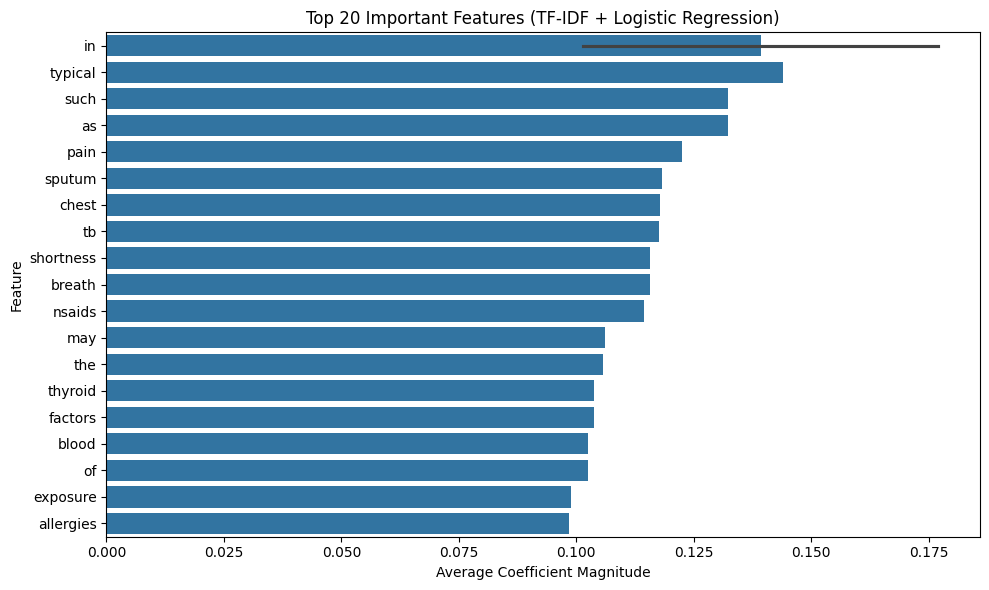

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


feature_names = vectorizer_risk.get_feature_names_out().tolist() + \
                vectorizer_symptoms.get_feature_names_out().tolist() + \
                vectorizer_signs.get_feature_names_out().tolist()


log_model = LogisticRegression(max_iter=1000)
log_model.fit(tfidf_combined, y_encoded)


coeffs = np.mean(np.abs(log_model.coef_), axis=0)
top_indices = np.argsort(coeffs)[-20:][::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=coeffs[top_indices], y=np.array(feature_names)[top_indices])
plt.title("Top 20 Important Features (TF-IDF + Logistic Regression)")
plt.xlabel("Average Coefficient Magnitude")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


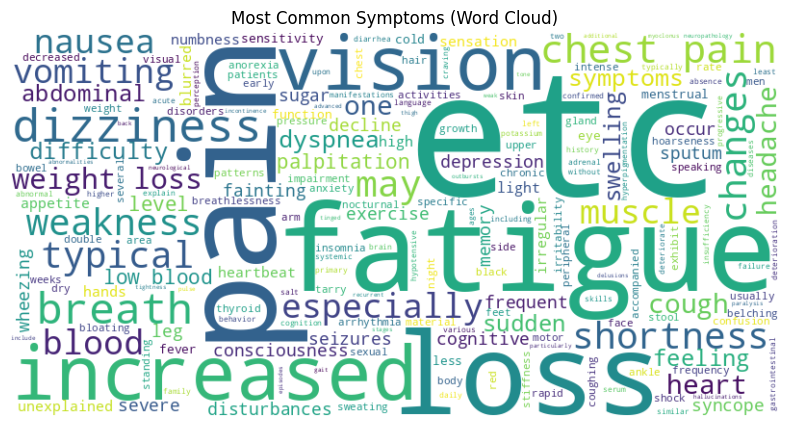

In [27]:
from wordcloud import WordCloud

all_symptoms = " ".join(df["Symptoms_Str"])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_symptoms)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Symptoms (Word Cloud)")
plt.show()


In [29]:

from google.colab import drive
drive.mount('/content/drive')


!pip install streamlit pyngrok --quiet
!pip install imbalanced-learn --quiet


app_code = """
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

st.set_page_config(page_title="Disease Category Predictor", layout="centered")

@st.cache_data
def load_data():
    from imblearn.over_sampling import SMOTE

    # Load raw data
    df = pd.read_csv("/content/drive/My Drive/disease_features.csv")
    df['Combined'] = df['Risk Factors'].fillna('') + ' ' + df['Symptoms'].fillna('') + ' ' + df['Signs'].fillna('')

    # TF-IDF
    tfidf = TfidfVectorizer()
    X = tfidf.fit_transform(df['Combined'].astype(str))

    # Original labels
    categories = np.array([
        "Cardiovascular", "Endocrine", "Neurological", "Cardiovascular", "Respiratory",
        "Cardiovascular", "Cardiovascular", "Respiratory", "Endocrine", "Neurological",
        "Gastrointestinal", "Gastrointestinal", "Cardiovascular", "Cardiovascular",
        "Cardiovascular", "Neurological", "Neurological", "Gastrointestinal", "Endocrine",
        "Infectious", "Cardiovascular", "Neurological", "Endocrine", "Infectious", "Gastrointestinal"
    ])
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(categories)

    # Apply SMOTE to balance categories
    smote = SMOTE(random_state=42, k_neighbors=1)
    X_bal, y_bal = smote.fit_resample(X, y)

    return df, X_bal, y_bal, tfidf, label_encoder, categories

df, X, y, tfidf, label_encoder, categories = load_data()

st.title("🧠 Disease Category Prediction")
st.markdown("Enter patient **risk factors, symptoms, and signs** below to predict a possible disease category.")

user_input = st.text_area("🩺 Input symptoms (e.g., chest pain, fever, headache):")

k = st.selectbox("🔢 Select value of k", [3, 5, 7])
metric = st.selectbox("📏 Choose Distance Metric", ["euclidean", "manhattan", "cosine"])

if st.button("🔍 Predict Disease Category"):
    if not user_input.strip():
        st.warning("Please enter at least one symptom or sign.")
    else:
        vec = tfidf.transform([user_input])
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X, y)
        pred = knn.predict(vec)
        predicted_label = label_encoder.inverse_transform(pred)[0]
        st.success(f"✅ **Predicted Disease Category:** {predicted_label}")

        distances, indices = knn.kneighbors(vec)
        st.subheader("🔎 Top Similar Cases from Dataset:")
        for i in indices[0]:
          if i < len(df):
            st.markdown(
                f"• **Category:** {categories[y[i]]}<br>"
                f"• **Symptoms:** {df.iloc[i]['Symptoms']}<br>"
                f"• **Signs:** {df.iloc[i]['Signs']}<br>"
                f"• **Risk Factors:** {df.iloc[i]['Risk Factors']}",
                unsafe_allow_html=True
            )
          else:
            st.markdown(
                f"• **Category:** {label_encoder.inverse_transform([y[i]])[0]}<br>"
                f"• *Synthetic case – no real patient data available*",
                unsafe_allow_html=True
            )
"""
with open("knn_app.py", "w") as f:
    f.write(app_code)

from pyngrok import conf, ngrok


conf.get_default().auth_token = "2vjG86MnszoygGjBXwPTkmLWYkF_mc9us4b8qTp9CTe3fGqG"


!pkill streamlit

public_url = ngrok.connect(addr="8501", proto="http")
print(f"🌐 Open your app here: {public_url}")


!streamlit run knn_app.py &

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🌐 Open your app here: NgrokTunnel: "https://ea8d-34-80-137-60.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.80.137.60:8501

  Stopping...
